# 1: Brief Description of the Problem and Data
For this mini-project, the objective is to use a generative adversarial network to transform photographs into paintings that mimic the style of Claude Monet. The task requieres generating 7k -> 10k Monet-style images from a set of provided photos. The performance is evaluated using the MiFID score, which assesses how well the images capture Monet's artistic style while penalizing memorization of the training data.

The Kaggle competition provides 300 Monet paintings and 7028 landscape photos, each 256x256 pixels. The dataset is unpaired, meaning there is no direct mapping between photos and Monet paintings, making it ideal for GANs like the CycleGAN.

# 2: Exploratory Data Analysis
## 2.1: Data Loading and Sample Images
First, we will load all of the images and then display sample images to get a sense of the styles/characteristics of both images.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


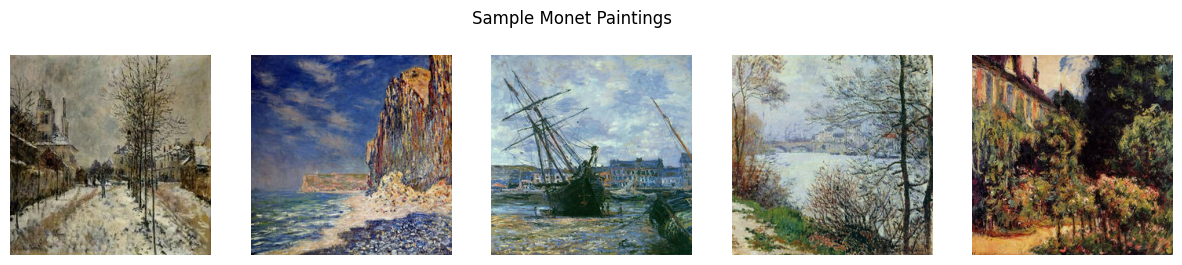

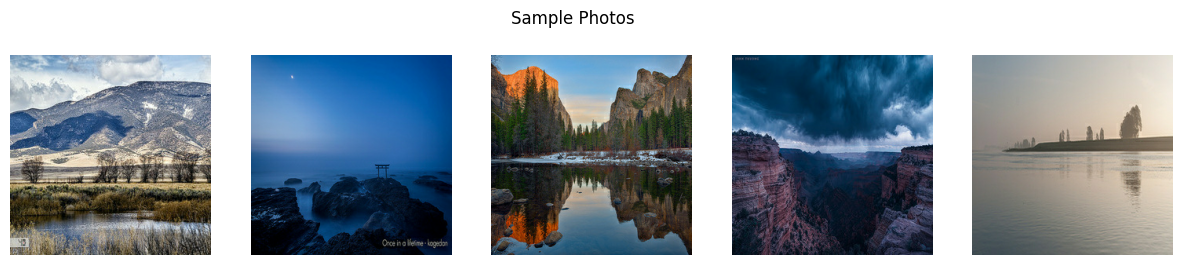

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

monet_tfrec_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_tfrec_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    return image

monet_files = tf.io.gfile.glob(monet_tfrec_path)
photo_files = tf.io.gfile.glob(photo_tfrec_path)

monet_dataset = tf.data.TFRecordDataset(monet_files).map(parse_tfrecord_fn)
photo_dataset = tf.data.TFRecordDataset(photo_files).map(parse_tfrecord_fn)

def display_samples(dataset, title, n_samples=5):
    plt.figure(figsize=(15, 3))
    for i, image in enumerate(dataset.take(n_samples)):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_samples(monet_dataset, 'Sample Monet Paintings')
display_samples(photo_dataset, 'Sample Photos')

## 2.2: Color Distribution Analysis
Next, we will analyze the RGB color distributions of both image types and plot the histograms

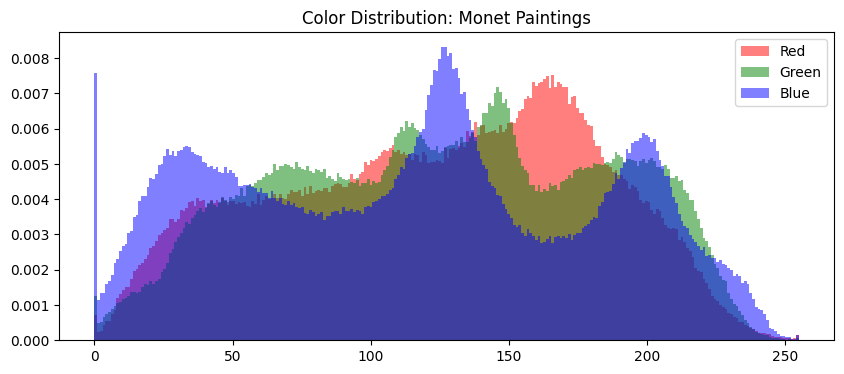

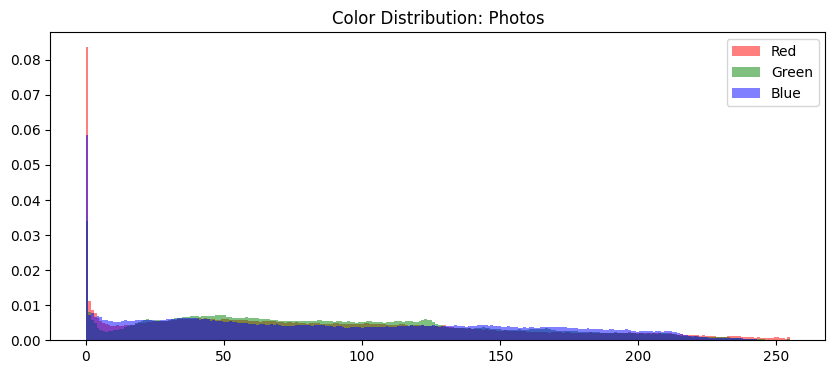

In [5]:
def plot_color_histogram(dataset, title, n_images=10):
    r, g, b = [], [], []
    for image in dataset.take(n_images):
        img = image.numpy().astype('uint8')
        r.extend(img[..., 0].ravel())
        g.extend(img[..., 1].ravel())
        b.extend(img[..., 2].ravel())
    
    plt.figure(figsize=(10, 4))
    plt.hist(r, bins=256, color='red', alpha=0.5, label='Red', density=True)
    plt.hist(g, bins=256, color='green', alpha=0.5, label='Green', density=True)
    plt.hist(b, bins=256, color='blue', alpha=0.5, label='Blue', density=True)
    plt.title(f'Color Distribution: {title}')
    plt.legend()
    plt.show()

plot_color_histogram(monet_dataset, 'Monet Paintings')
plot_color_histogram(photo_dataset, 'Photos')

The histogram for the Monet paintings show distinct peaks across certain color changes, reflecting Monet's preference for specific color palletes and styles. In constrast, the landscape photos show a more uniform distribution due to the diversity of color in the real world.

# 3: Model Building

For this project, we will implement a CycleGAN to transform photos into Monet-style paintings. CycleGAN is ideal for unpaired image-to-image translation, suiting our dataset. To keep within the Kaggle runtime limit, performance will have to be sacrified for computational complexity.

## 3.1 Architecture

### 3.1.1 Generators
Two generators are used:
* $G$: Transforms photos into Monet-style paintings
* $F$: Transforms Monet paintings back to photos

Both generators utilize a simplified CNN-based architecture:
* Input: 256x256x3 images normalized to $[-1, 1]$
* Conv2D: 32 filters, kernel 3, padding 'same', activation 'relu'
* Conv2D: 3 filters, kernel 3, padding 'same', activation 'tanh'
* Output: 256x256x3 images

### 3.1.2 Discriminators
Two discriminators assess image realism:
* $D_M$: Distinguishes real Monet paintings from generated ones.
* $D_P$: Distinguishes real photos from generated ones.

Both discriminators utilize a simplified CNN-based architecture:
* Input: 256x256x3 images
* Conv2D: 32 filters, kernel 3, padding 'same', activation 'relu'
* Conv2D: 1 filter, kernel 3, padding 'same', activation 'sigmoid'
* Output: 256x256 prediction map

### 3.1.3 Training Details
The training utilizes the Adam optimizer with a learning rate of 0.0002 and beta_1 = 0.5. The adversarial loss uses binary cross-entropy, while the cycle consistency loss utilizes mean absolute error with $\lambda = 10$. Mixed-precision training is employed for efficiency. The batch size is 16, and the model is trained for 5 epochs with 90 steps per epoch.

## 3.2 Implementation

In [3]:
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
import os
import zipfile
from PIL import Image
import io

from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

BATCH_SIZE = 16
LAMBDA_CYCLE = 10
NUM_EPOCHS = 5
STEPS_PER_EPOCH = 90
TOTAL_PHOTOS = 7028

def parse_tfrecord(example):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1.0
    return image

monet_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

monet_dataset = tf.data.TFRecordDataset(monet_files)\
    .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(300)\
    .batch(BATCH_SIZE)\
    .repeat()\
    .prefetch(tf.data.AUTOTUNE)

photo_dataset = tf.data.TFRecordDataset(photo_files)\
    .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(10000)\
    .batch(BATCH_SIZE)\
    .repeat()\
    .prefetch(tf.data.AUTOTUNE)

photo_gen_dataset = tf.data.TFRecordDataset(photo_files)\
    .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE)

def build_generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    outputs = tf.keras.layers.Conv2D(3, 3, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)

def build_discriminator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    outputs = tf.keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

generator_photo_to_monet = build_generator()
generator_monet_to_photo = build_generator()
discriminator_monet = build_discriminator()
discriminator_photo = build_discriminator()

optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_F = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D_M = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D_P = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

BCE = BinaryCrossentropy(from_logits=True)
MAE = MeanAbsoluteError()

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_photo_to_monet(real_photo)
        fake_photo = generator_monet_to_photo(real_monet)
        
        D_M_real = discriminator_monet(real_monet)
        D_M_fake = discriminator_monet(fake_monet)
        D_P_real = discriminator_photo(real_photo)
        D_P_fake = discriminator_photo(fake_photo)
        
        D_M_loss = 0.5 * (BCE(D_M_real, tf.ones_like(D_M_real)) + BCE(D_M_fake, tf.zeros_like(D_M_fake)))
        D_P_loss = 0.5 * (BCE(D_P_real, tf.ones_like(D_P_real)) + BCE(D_P_fake, tf.zeros_like(D_P_fake)))
        
        adv_loss_G = BCE(D_M_fake, tf.ones_like(D_M_fake))
        adv_loss_F = BCE(D_P_fake, tf.ones_like(D_P_fake))
        
        reconstructed_photo = generator_monet_to_photo(fake_monet)
        reconstructed_monet = generator_photo_to_monet(fake_photo)
        cycle_loss_forward = MAE(real_photo, reconstructed_photo)
        cycle_loss_backward = MAE(real_monet, reconstructed_monet)
        total_cycle_loss = cycle_loss_forward + cycle_loss_backward
        
        total_gen_loss = adv_loss_G + adv_loss_F + LAMBDA_CYCLE * total_cycle_loss
    
    grads_D_M = tape.gradient(D_M_loss, discriminator_monet.trainable_variables)
    optimizer_D_M.apply_gradients(zip(grads_D_M, discriminator_monet.trainable_variables))
    
    grads_D_P = tape.gradient(D_P_loss, discriminator_photo.trainable_variables)
    optimizer_D_P.apply_gradients(zip(grads_D_P, discriminator_photo.trainable_variables))
    
    grads_G = tape.gradient(total_gen_loss, generator_photo_to_monet.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, generator_photo_to_monet.trainable_variables))
    
    grads_F = tape.gradient(total_gen_loss, generator_monet_to_photo.trainable_variables)
    optimizer_F.apply_gradients(zip(grads_F, generator_monet_to_photo.trainable_variables))
    
    del tape
    return D_M_loss, D_P_loss, total_gen_loss

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    for step, (monet_batch, photo_batch) in enumerate(zip(monet_dataset, photo_dataset)):
        if step >= STEPS_PER_EPOCH:
            break
        D_M_loss, D_P_loss, gen_loss = train_step(monet_batch, photo_batch)
        if step % 25 == 0:
            print(f'Step {step}: D_M_loss={D_M_loss:.4f}, D_P_loss={D_P_loss:.4f}, gen_loss={gen_loss:.4f}')

# Generate submission images
with zipfile.ZipFile('/kaggle/working/images.zip', 'w') as zipf:
    image_count = 0
    for photo_batch in photo_gen_dataset:
        fake_monet_batch = generator_photo_to_monet(photo_batch)
        fake_monet_batch = (fake_monet_batch + 1) * 127.5
        fake_monet_batch = tf.cast(fake_monet_batch, tf.uint8)
        for fake_monet in fake_monet_batch:
            image_count += 1
            img = Image.fromarray(fake_monet.numpy())
            img_byte_arr = io.BytesIO()
            img.save(img_byte_arr, format='JPEG')
            zipf.writestr(f'{image_count}.jpg', img_byte_arr.getvalue())
            if image_count >= TOTAL_PHOTOS:
                break
        if image_count >= TOTAL_PHOTOS:
            break

Epoch 1/5


I0000 00:00:1745649283.224675    1317 cuda_dnn.cc:529] Loaded cuDNN version 90300


Step 0: D_M_loss=0.7590, D_P_loss=0.7479, gen_loss=10.0806
Step 25: D_M_loss=0.7322, D_P_loss=0.7254, gen_loss=7.8967
Step 50: D_M_loss=0.7107, D_P_loss=0.6923, gen_loss=5.4635
Step 75: D_M_loss=0.6765, D_P_loss=0.6588, gen_loss=4.4289
Epoch 2/5
Step 0: D_M_loss=0.6657, D_P_loss=0.6424, gen_loss=4.3880
Step 25: D_M_loss=0.6287, D_P_loss=0.6020, gen_loss=3.6583
Step 50: D_M_loss=0.5988, D_P_loss=0.5899, gen_loss=3.4946
Step 75: D_M_loss=0.5745, D_P_loss=0.5639, gen_loss=3.3397
Epoch 3/5
Step 0: D_M_loss=0.5842, D_P_loss=0.5660, gen_loss=3.2214
Step 25: D_M_loss=0.5617, D_P_loss=0.5433, gen_loss=3.0863
Step 50: D_M_loss=0.5487, D_P_loss=0.5380, gen_loss=2.9343
Step 75: D_M_loss=0.5465, D_P_loss=0.5345, gen_loss=2.8668
Epoch 4/5
Step 0: D_M_loss=0.5399, D_P_loss=0.5269, gen_loss=2.7649
Step 25: D_M_loss=0.5375, D_P_loss=0.5318, gen_loss=2.6425
Step 50: D_M_loss=0.5372, D_P_loss=0.5215, gen_loss=2.6287
Step 75: D_M_loss=0.5221, D_P_loss=0.5187, gen_loss=2.5807
Epoch 5/5
Step 0: D_M_loss=0.

# Resources
https://www.kaggle.com/competitions/gan-getting-started

https://github.com/JeffreyLind3/CSCA5642Week5